# <div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Music Genre Classification using Machine Learning
-------------------------------------------------

### Introduction

Music genre classification is of great importance in the field of machine learning. It enables various applications such as personalized recommendations, music organization, content licensing, and music analysis. In this notebook, my goal is to leverage different ML methods to automatically classify 10 distinct music genres using the GTZAN dataset. The dataset consists of 10 genres, each containing 100 music samples.

Genres included in the dataset:
- Blues
- Classical
- Country
- Disco
- Hip Hop
- Jazz
- Metal
- Pop
- Reggae
- Rock

### Dataset Source

The GTZAN dataset can be accessed through the following link on Kaggle: [GTZAN Dataset - Music Genre Classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

### Objective

The primary objective of this notebook is to explore and apply various ML methods for the automatic classification of music genres. By implementing feature engineering, model training, and evaluation techniques, I aim to develop accurate and efficient classifiers capable of identifying the genre of a given music sample.

### Implementation

Throughout this notebook, I will employ a range of ML algorithms and techniques such as data preprocessing, feature extraction, model selection, and evaluation. By experimenting with different approaches, I seek to identify the most effective methods for achieving high classification accuracy and robustness in music genre classification tasks.

Let's dive in and explore the fascinating world of music genre classification!

In [1]:
# Install the Librosa library
# Librosa is used for music and audio analysis. It provides the tools necessary for music genre classification,
# including audio feature extraction such as Mel-frequency cepstral coefficients (MFCCs), spectral contrast, 
# and zero-crossing rate. This will help in accurately classifying different genres based on their audio patterns.

!pip install librosa

In [2]:
!pip install scikit-learn

In [3]:
# Standard library imports
import warnings

# Third-party imports for data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Audio processing library
import librosa
import librosa.display

# Machine learning preprocessing and model selection
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Deep learning libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Statistical distributions for randomized search
from scipy.stats import loguniform, randint

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Set up the aesthetics for seaborn plots
sns.set(style="whitegrid")

# Ensure that plots are displayed in the Jupyter Notebook
%matplotlib inline

2024-04-27 20:00:37.809357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 20:00:37.809480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 20:00:37.938777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Exploring a Sample from the GTZAN Dataset

I start by examining the first sample from the pop music category within the GTZAN Music dataset. 

For further analysis, the complete dataset, which includes tracks from 10 different genres, is available on Kaggle:
[GTZAN Dataset - Music Genre Classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

In [4]:
audio_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00000.wav'
audio, sr = librosa.load(audio_path)

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Visualizing Audio Data: Waveform Plot of a Pop Music Sample

The GTZAN Music Genre Classification dataset comprises music samples from various genres, each with a uniform duration of 30 seconds. In the analysis below, I visualize waveform of the selected pop music sample to examine its audio characteristics.

It's crucial to highlight that the dataset also includes a version where each 30-second track is subdivided into ten segments, each lasting 3 seconds. This segmentation approach effectively increases the dataset's volume by providing more samples for training, which can enhance the accuracy of genre classification models by offering more granular data for analysis.

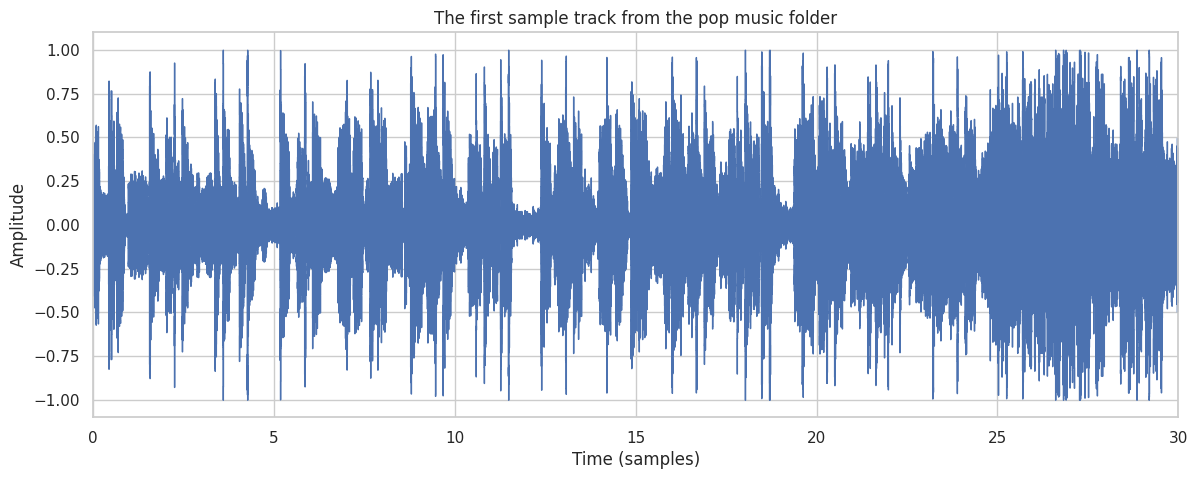

In [5]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('The first sample track from the pop music folder')
plt.xlim([0,30])
plt.show()

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Analyzing Audio Features in the GTZAN Dataset

The `features_3_sec.csv` file from the [GTZAN Music Genre Classification dataset on Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) includes several audio features extracted from segmented 3-second clips of music tracks. Each feature provides insights into different aspects of the audio signals. Below, we briefly describe each feature and will later illustrate them using a specific music track from the dataset.

1. **Chroma STFT (Short-Time Fourier Transform)**: Measures the intensity of different pitches in a music track, providing a representation of the audio in terms of its harmonic content across 12 different pitch classes.

2. **RMS (Root Mean Square) Mean**: Indicates the average power or loudness of the audio signal.

3. **Spectral Centroid Mean**: Represents the "center of mass" of the spectrum, giving a sense of the brightness of a sound.

4. **Spectral Bandwidth Mean**: Measures the width of the band of light at half the peak maximum and effectively indicates the range of frequencies present in the sound.

5. **Rolloff Mean**: The frequency below which a specified percentage (typically 85% to 95%) of the total spectral energy lies, highlighting the shape of the audio spectrum.

6. **Zero Crossing Rate Mean**: The rate at which the signal changes signs, which can indicate the noisiness or the complexity of a sound.

7. **Harmony Mean**: Extracts the harmonic components of the audio, which are important for the perception of musical notes.

8. **Perceptual Sharpness Mean**: Measures the sharpness or brightness of the audio, which affects how listeners perceive the "edge" or clarity of a sound.

9. **Tempo**: The speed at which a piece of music is played, calculated in beats per minute (BPM).

10. **MFCC (Mel Frequency Cepstral Coefficients) Mean**: Describes the overall shape of the spectral envelope and is widely used in audio signal processing and speech recognition for timbre and speech clarity characterization.

In the following sections, I will visualize each of these features using the pop music track previously mentioned to better understand how they represent different aspects of the music.

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Chroma STFT

Chroma STFT (Short-Time Fourier Transform) is a feature representation used to capture the pitch content of an audio signal. This process involves mapping the audio onto a 12-dimensional chroma space, which corresponds to the 12 pitch classes commonly found in Western music.

The computation of Chroma STFT begins with the application of the Short-Time Fourier Transform (STFT) to the audio signal. STFT analyzes the spectral content over time by breaking the signal into short segments and computing the Fourier Transform separately on each segment. This provides a time-varying spectral representation.

Following the STFT, the spectral information is aggregated into chroma features. These chroma features summarize the entire spectrum by focusing on the 12 different pitch classes, effectively reducing the complexity of the data while retaining essential information about the pitch content. This makes Chroma STFT particularly useful for tasks that involve recognizing musical notes or chords, regardless of the specific octaves in which they occur.

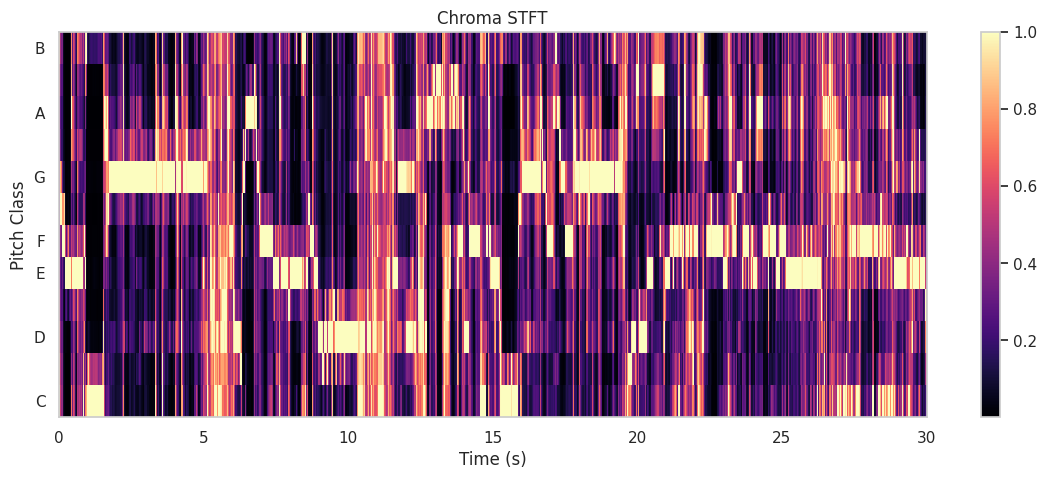

In [6]:
chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.title('Chroma STFT')
plt.show()

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## RMS Mean

RMS Mean, or Root Mean Square Mean, is a key audio feature that represents the average energy or amplitude of an audio signal over time. It serves as a summary measure of the overall loudness or intensity of the audio.

The computation of RMS Mean involves several steps:
1. **Calculating the RMS for each time frame**: The RMS value for a given time frame is calculated by taking the square root of the average of the squares of the sample amplitudes within that frame. This method ensures that all amplitude values are non-negative, providing a true measure of the signal's power.
2. **Averaging RMS values**: Once the RMS values are calculated for each time frame, the RMS Mean is obtained by averaging these values. This average provides a consistent measure of the audio signal's loudness across its entire duration.

By quantifying the signal's loudness, the RMS Mean is particularly useful in applications where audio levels need to be normalized or compared across different recordings.

In [7]:
rms = librosa.feature.rms(y=audio)
rms_mean = rms.mean()

print("RMS Mean:", rms_mean)

RMS Mean: 0.18578337


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Spectral Centroid Mean

The Spectral Centroid Mean is a crucial audio feature that represents the average "center of mass" of the spectrum of an audio signal over time. It effectively measures the weighted mean of the frequencies present in the signal, where their magnitudes serve as the weights. This feature is computed as the mean of the spectral centroid values across different time frames.

### Importance
The Spectral Centroid Mean provides a summary measure of the overall tonal character or spectral brightness of the audio signal. A higher spectral centroid indicates a sound that is perceived as "brighter" or having more high frequencies, while a lower centroid suggests a "darker" sound with more low frequencies.



In [8]:
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)
spectral_centroids_mean = spectral_centroids.mean()

print("Spectral Centroid Mean:", spectral_centroids_mean)

Spectral Centroid Mean: 3422.0718638777685


/tmp/ipykernel_24/119333386.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


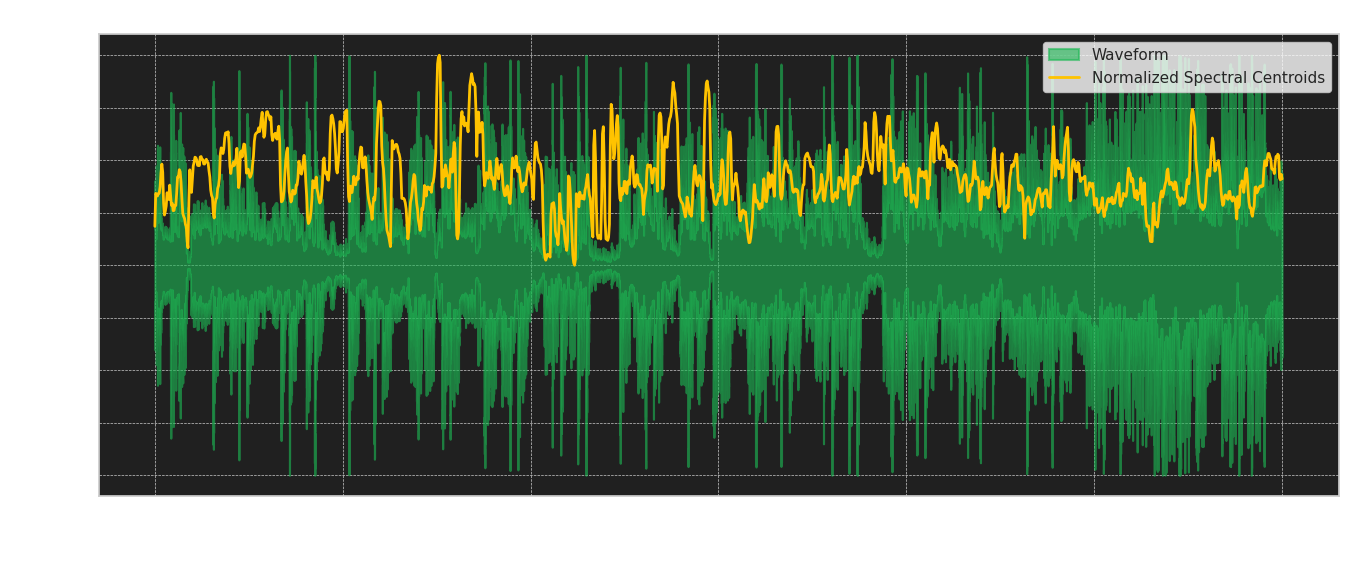

In [9]:
# Calculate the spectral centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)

# Computing the time variable for visualization
frames = range(len(spectral_centroids[0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use('seaborn-dark-palette')

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# Spectral centroids plot
plt.plot(t, normalize(spectral_centroids[0]), color='#FFC300', linewidth=2, label='Normalized Spectral Centroids')

# Enhancing the plot
plt.title('Waveform and Normalized Spectral Centroids', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Spectral Bandwidth Mean

Spectral Bandwidth Mean is an analytical metric that represents the average value of the spectral bandwidth of an audio signal over time. This metric quantifies the mean spread or width of the frequencies in the signal's spectrum.

### Importance 

Spectral Bandwidth provides crucial information about the spectral complexity or variation in frequency content of the audio signal. Essentially, it measures how much the energy of a signal is spread across different frequencies. A larger bandwidth indicates a broader spread of frequencies, suggesting a more complex sound, while a narrower bandwidth suggests a purer tone with fewer frequency components.




In [10]:
spectral_bandwidths = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
spectral_bandwidths_mean = spectral_bandwidths.mean()

print("Spectral Bandwidth Mean:", spectral_bandwidths_mean)

Spectral Bandwidth Mean: 3409.782871188017


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Spectral Rolloff Mean

Spectral Rolloff Mean is a significant audio feature that represents the average frequency below which a specified percentage of the total spectral energy of an audio signal is concentrated. This metric provides a summary measure of the overall high-frequency content or cutoff frequency of the audio signal's spectrum.

## Significance of Spectral Rolloff

The spectral rolloff point is an important descriptor in audio signal processing as it effectively captures the boundary of the higher frequencies in an audio spectrum. A lower rolloff point indicates that most of the energy is concentrated in the lower frequencies, while a higher rolloff point suggests a presence of substantial high-frequency energy, potentially indicating brightness or sharpness in the sound.


In [11]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
spectral_rolloff_mean = spectral_rolloff.mean()

print("Spectral Rolloff Mean:", spectral_rolloff_mean)

Spectral Rolloff Mean: 7953.037936394287


/tmp/ipykernel_24/2848811353.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


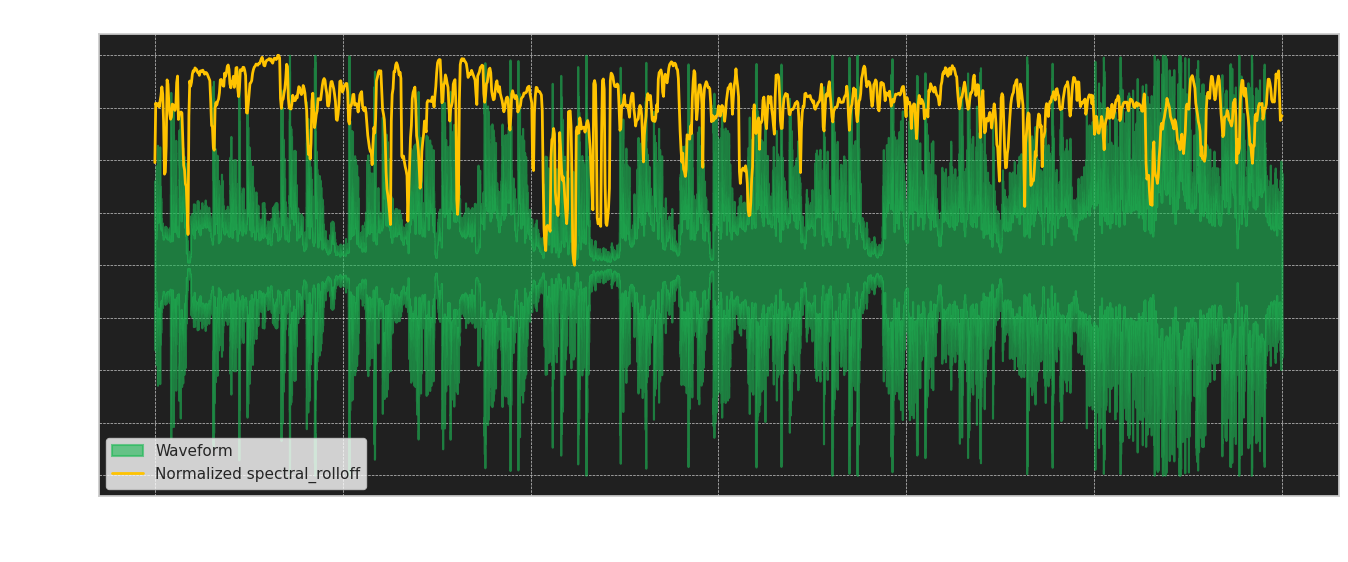

In [12]:
# Computing the time variable for visualization
frames = range(len(spectral_rolloff [0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use('seaborn-dark-palette')

# Plotting the spectral_rolloff along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# chroma_cens plot
plt.plot(t, normalize(spectral_rolloff[0]), color='#FFC300', linewidth=2, label='Normalized spectral_rolloff')

# Enhancing the plot
plt.title('Waveform and Normalized spectral_rolloff', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Zero-Crossing Rate Mean

The Zero-Crossing Rate Mean is a fundamental audio analysis metric that represents the average rate at which an audio signal crosses the zero axis over time. This measure provides a valuable insight into the temporal variations or the frequency of rapid changes in the audio signal.

## Understanding Zero-Crossing Rate

Zero-crossing rate is a critical parameter in digital signal processing that quantifies how frequently the amplitude of the audio waveform crosses the zero value. This rate is particularly indicative of the noise level and timbral characteristics of the signal. High zero-crossing rates are often associated with noisy or complex sounds, while low rates typically indicate tonal or harmonic sounds.


In [13]:
zero_crossing_rates = librosa.feature.zero_crossing_rate(y=audio)
zero_crossing_rates_mean = zero_crossing_rates.mean()

print("Zero-Crossing Rate Mean:", zero_crossing_rates_mean)

Zero-Crossing Rate Mean: 0.1267201245891338


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Harmony Mean

The Harmony Mean is a quantifiable audio feature that represents the average level of harmony or consonance in an audio signal over time. This metric provides a summary measure of the overall harmonic content and musical tonality, offering insights into the structural and aesthetic qualities of music and sound.

## Significance of Harmony in Audio Analysis

Harmony, in the context of music and audio, refers to the simultaneous combination of tones, especially when blended into chords that are pleasing to the ear. Consonance, or the degree of harmony, is crucial for understanding the musicality and mood conveyed by an audio signal. A higher harmony mean suggests a richer and more consonant harmonic structure, which is typical in melodious and harmonically complex music. Conversely, a lower harmony mean might indicate dissonance, tension, or a more percussive and rhythmic nature of the sound.



In [14]:
chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)
harmony_mean = chroma_cens.mean()

print("Harmony Mean:", harmony_mean)

Harmony Mean: 0.23584463


/tmp/ipykernel_24/930052618.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


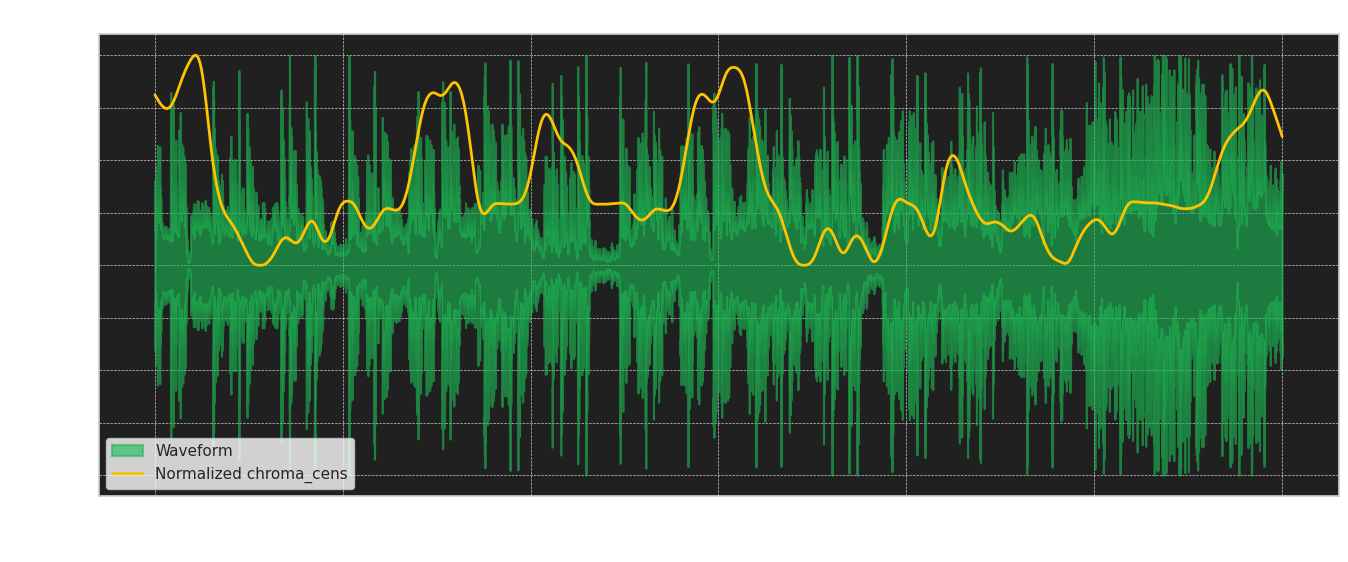

In [15]:
# Computing the time variable for visualization
frames = range(len(chroma_cens[0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use('seaborn-dark-palette')

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# chroma_cens plot
plt.plot(t, normalize(chroma_cens[0]), color='#FFC300', linewidth=2, label='Normalized chroma_cens')

# Enhancing the plot
plt.title('Waveform and Normalized chroma_cens', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Tempo Mean

The Tempo Mean is a single scalar value that quantifies the average perceived tempo, measured in beats per minute (BPM), of an audio signal over time. This metric offers a summary measure of the overall tempo or rhythmic characteristics of the audio signal, providing insights into its rhythmic pace and consistency.

## Importance of Tempo in Audio Analysis

Tempo is a fundamental aspect of music and audio that relates to the speed or pace at which the piece is played. It is crucial for determining the mood and style of the music, influencing how listeners perceive and react to the sound. A faster tempo typically conveys energy and excitement, while a slower tempo might evoke calmness or solemnity.



In [16]:
tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
tempo_mean = tempo.mean()

print("Tempo Mean (BPM):", tempo_mean)

Tempo Mean (BPM): 89.10290948275862


In [17]:
import sklearn
from sklearn import preprocessing



<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

# Mel Frequency Cepstral Coefficients (MFCC)

Mel Frequency Cepstral Coefficients (MFCC) are a feature commonly used in audio signal processing, particularly in the areas of speech recognition and music analysis. These coefficients effectively represent the short-term power spectrum of an audio signal, derived through a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

## Importance of MFCC in Audio Analysis

MFCCs are crucial because they closely approximate the human auditory system's response and are robust for voice identification, even in noisy environments. Their ability to capture important spectral properties makes them highly effective for various tasks in audio analysis, including speaker identification, speech recognition, and music genre classification.



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


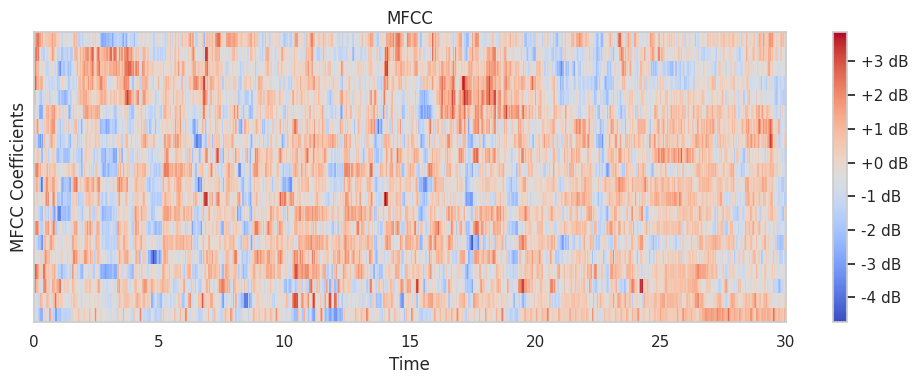

In [18]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Apply Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>


# Loading the Data

In this initial step, I loaded the feature matrix from features_3_sec.csv into a pandas DataFrame. This dataset comprises a comprehensive matrix with dimensions indicating it contains 9990 entries, each characterized by 60 distinct features.


In [19]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')

In [20]:
df.sample(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
9235,rock.00024.3.wav,66149,0.430203,0.070674,0.177681,0.001052,2359.178048,59890.542495,2041.671286,51518.651817,...,17.862217,-11.618786,37.039604,2.486346,22.528259,-4.214647,35.405956,-0.825204,28.457527,rock
6515,metal.00052.3.wav,66149,0.524433,0.070018,0.233580,0.002221,2999.672823,214481.212758,2330.409399,160090.720968,...,44.483852,-6.793023,42.847862,3.383492,30.525398,-3.757394,23.816156,4.953286,32.339939,metal
5150,jazz.00015.8.wav,66149,0.300283,0.084222,0.063153,0.000339,1795.551948,72940.966522,2038.495593,79063.856300,...,47.275257,-11.720072,70.569824,0.345093,59.375393,-4.759012,60.111725,0.868609,70.917679,jazz
2821,country.00082.6.wav,66149,0.373719,0.090344,0.153497,0.002395,2344.775984,394644.408845,2360.503215,98000.737647,...,23.891903,-6.669863,48.740772,6.668455,17.325994,-5.398708,49.018806,-2.480245,35.228096,country
9912,rock.00092.2.wav,66149,0.452496,0.067200,0.102053,0.000199,2332.150837,56417.936961,2015.233941,14751.781284,...,34.394329,-16.713825,30.026983,-1.417212,24.359451,-16.680574,22.053429,-0.461400,35.607296,rock


In [21]:
df.shape


(9990, 60)

In [22]:
df.iloc[1,:]   # here, the name of the features has been listed

filename                   blues.00000.1.wav
length                                 66149
chroma_stft_mean                    0.343065
chroma_stft_var                     0.086147
rms_mean                            0.112699
rms_var                              0.00145
spectral_centroid_mean           1816.693777
spectral_centroid_var           90525.690866
spectral_bandwidth_mean          2010.051501
spectral_bandwidth_var          65671.875673
rolloff_mean                     3869.682242
rolloff_var                    672244.760273
zero_crossing_rate_mean             0.087173
zero_crossing_rate_var               0.00103
harmony_mean                       -0.000099
harmony_var                          0.00495
perceptr_mean                      -0.000103
perceptr_var                        0.004854
tempo                             123.046875
mfcc1_mean                       -125.590706
mfcc1_var                        2038.344238
mfcc2_mean                        122.421227
mfcc2_var 

Let's see is there any NaN value in different columns of the dataframe 🧐

In [23]:
df.isna().sum() 

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

it seems that there is no NaN at all 😊

I have removed the initial column, 'filename', from the DataFrame, as it does not influence the classification results.

In [24]:
df = df.drop('filename', axis = 1)


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Exploratory Data Analysis (EDA)

### Correlation Heatmap

The correlation heatmap displayed below offers a visual representation of the relationships between features. It serves as a valuable tool for identifying which features are most closely related to each other. This insight can assist in understanding feature dependencies, which may influence subsequent modeling decisions.

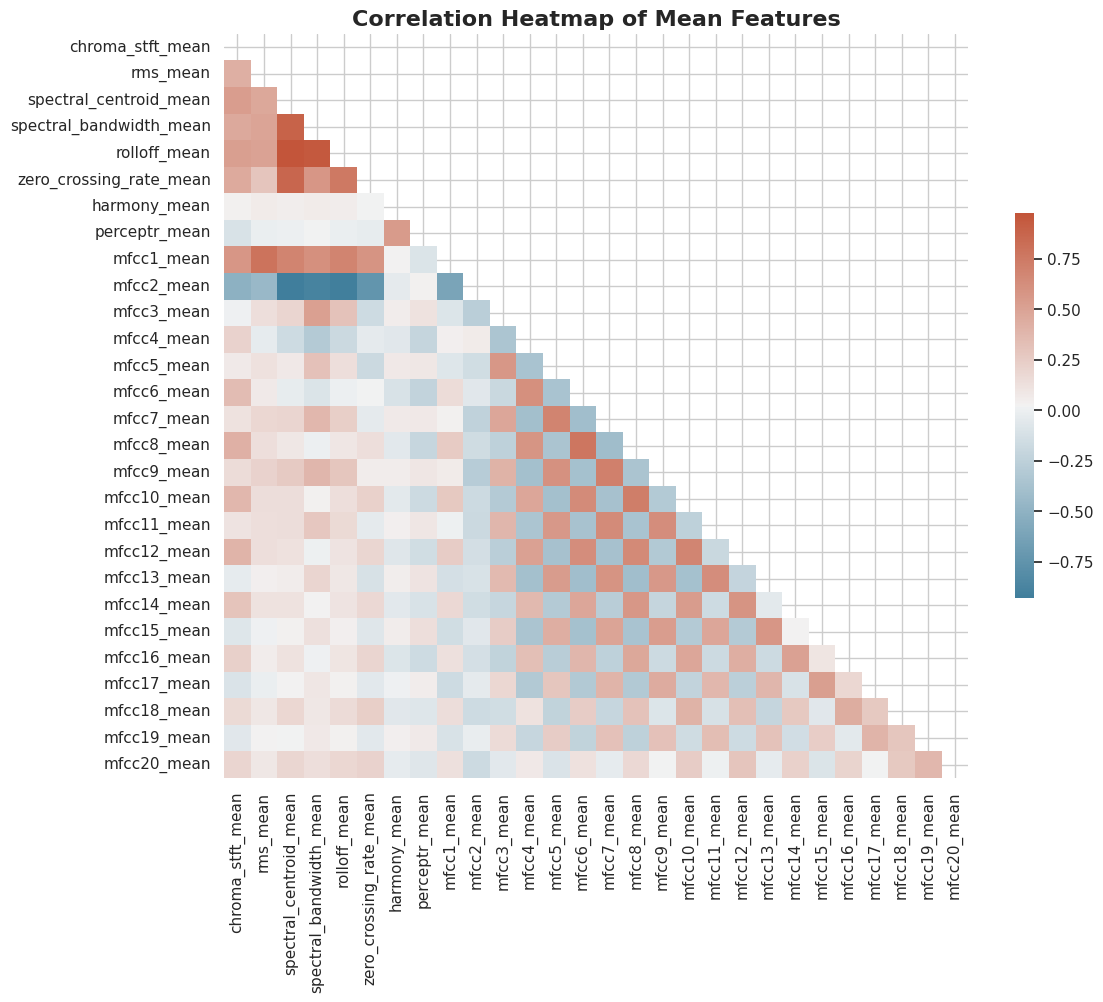

In [25]:
mean_columns = df.filter(regex='_mean$')

correlation_matrix = mean_columns.corr()

# Create a boolean mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=False, linewidths=0,
            cbar_kws={"shrink": .5}, square=True)

# Add a title to the heatmap
plt.title('Correlation Heatmap of Mean Features', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

### Box Plot for Genres Distributions

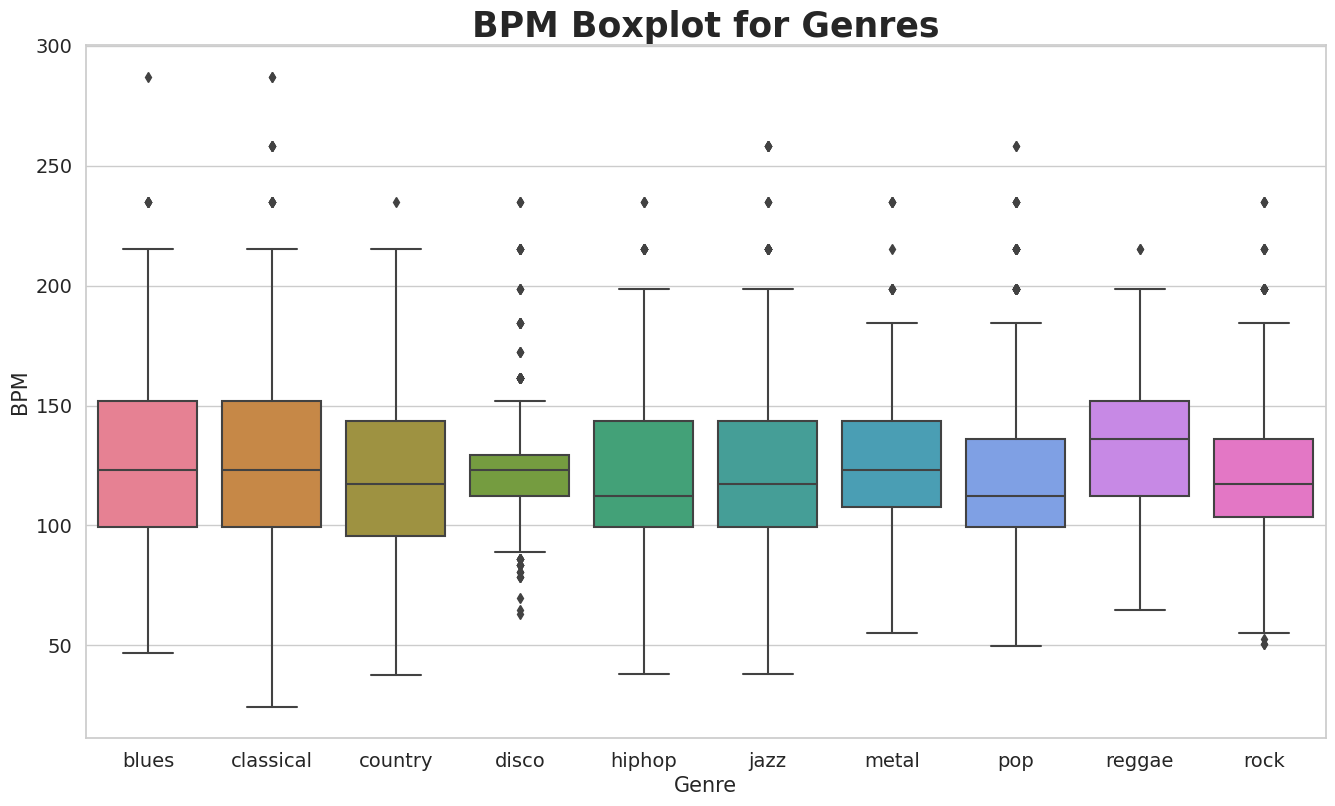

In [26]:
# Subset the DataFrame to include only the 'label' and 'tempo' columns
x = df[["label", "tempo"]]

# Create the plot
f, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x="label", y="tempo", data=x, palette='husl')

# Styling the plot with titles and labels
plt.title('BPM Boxplot for Genres', fontsize=25, fontweight='bold')
plt.xlabel("Genre", fontsize=15)
plt.ylabel("BPM", fontsize=15)

# Setting the font size for x and y ticks for better readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Starting with Machine Learning Methods

Before diving into specific machine learning models, we need to set up our data appropriately:

1. **Define `X` and `y`:**
   - **`X`** represents our feature matrix, consisting of all columns except the last one.
   - **`y`** is our target vector, contained in the last column named 'label'.

2. **Split the Data:**
   - The dataset is divided into 80% for training and 20% for testing. This is a common practice to evaluate the performance of machine learning models on unseen data.

By preparing the data in this manner, we ensure that we have a solid foundation for applying various machine learning techniques.

In [27]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)


## Encoding Music Genres with LabelEncoder

To facilitate the application of machine learning algorithms, which typically operate on numeric data, we need to convert the categorical labels in our target column `y` into a numeric format:

- **Using `LabelEncoder`:**
  - `LabelEncoder` from Scikit-learn is utilized to transform each unique music genre into a specific integer. This encoder assigns a unique integer to each distinct string value in the column.

In [28]:
labelencoder = LabelEncoder()

y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)


In [29]:
len(labelencoder.classes_)

10

## Feature Scaling with StandardScaler

When working with machine learning algorithms, it's important to ensure that the feature data is on a consistent scale. This is especially crucial for algorithms that are sensitive to the magnitude of input features, such as Support Vector Machines (SVM) and k-nearest neighbors (k-NN). Feature scaling helps improve the convergence of steepest descent algorithms, which are commonly used in machine learning optimizations.

### Using `StandardScaler` from Scikit-learn

`StandardScaler` is a preprocessing utility in Scikit-learn that standardizes features by removing the mean and scaling to unit variance. This process, often called Z-score normalization, transforms the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

Here's how to apply `StandardScaler` to our training and testing datasets:

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Support Vector Machine (SVM)

Support Vector Machine (SVM) is a robust and versatile machine learning algorithm used for both classification and regression tasks. It is particularly well-suited for classification of complex but small- or medium-sized datasets. SVM works by finding the hyperplane that best separates the data into classes with the maximum margin. 

Effective tuning of SVM hyperparameters is essential to maximize the model's performance. These hyperparameters include the kernel type, the penalty parameter C, and gamma. `GridSearchCV` facilitates this by exhaustively searching through a specified grid of hyperparameter values and determining the combination that yields the best performance through cross-validation. This systematic approach not only enhances the model's accuracy but also its generalizability to new data. I have applied `GridSearchCV` to other machine learning methods as well to ensure optimal performance across different algorithms.

In [31]:
# Define the parameter distribution for SVM
param_dist_svm = {
    'C': loguniform(1e-4, 1e+1),  # Narrower range for C
    'kernel': ['linear', 'rbf'],  # Only linear and RBF kernels
    # 'gamma': loguniform(1e-4, 1e-3)  # Consider removing if using a linear kernel
}

# Create the SVM classifier and randomized search object
svm = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(
    svm, param_distributions=param_dist_svm, n_iter=50,  # Reduced number of iterations
    scoring='accuracy', n_jobs=-1, random_state=42  # Use all available cores
)

# Fit the randomized search to the data
random_search_svm.fit(X_train, y_train)

# Evaluate the SVM model with the best parameters on the test set
best_svm = random_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Evaluate the SVM model on the training set
y_train_pred_svm = best_svm.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)

print("Train SVM Accuracy:", train_accuracy_svm)
print("Test SVM Accuracy:", test_accuracy_svm)

Train SVM Accuracy: 0.994994994994995
Test SVM Accuracy: 0.9309309309309309


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Decision Tree (DT)

Decision Tree (DT) is a popular and intuitive machine learning algorithm used for both classification and regression tasks. It operates by breaking down a dataset into smaller and smaller subsets based on different criteria, effectively building a tree-like model of decisions. Each node in the decision tree represents a feature in the dataset that leads to a decision, and each leaf node represents a class label or a regression outcome. Decision Trees are easy to interpret and visualize, making them an excellent choice for initial data exploration and analysis.

In [32]:
# Define the parameter distribution for Decision Tree
param_dist_dt = {
    'max_depth': randint(1, 51),  # Integer range [1, 50]
    'min_samples_split': randint(2, 11),  # Integer range [2, 10]
    'min_samples_leaf': randint(1, 11),  # Integer range [1, 10]
    'criterion': ['gini', 'entropy'],  # Categorical
    # Consider adding 'max_leaf_nodes': randint(2, 50) for additional pruning
}

# Create the Decision Tree classifier and randomized search object
dt = DecisionTreeClassifier(random_state=42)
random_search_dt = RandomizedSearchCV(
    dt, param_distributions=param_dist_dt, n_iter=50,  # Reduced number of iterations
    scoring='accuracy', n_jobs=-1, random_state=42  # Use all available cores
)

# Fit the randomized search to the data
random_search_dt.fit(X_train, y_train)

# Evaluate the Decision Tree model with the best parameters on the test set
best_dt = random_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
test_accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Evaluate the Decision Tree model on the training set
y_train_pred_dt = best_dt.predict(X_train)
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)

print("Train DT Accuracy:", train_accuracy_dt)
print("Test DT Accuracy:", test_accuracy_dt)

Train DT Accuracy: 0.9568318318318318
Test DT Accuracy: 0.6676676676676677


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Random Forest (RF)

Random Forest (RF) is an ensemble learning technique that builds upon the simplicity of decision trees by combining multiple such trees to form a more powerful model. By aggregating the decisions of a multitude of decision trees, each trained on different subsets of the same data, Random Forests reduce the risk of overfitting and typically provide much higher accuracy than individual decision trees. It is highly effective for classification and regression tasks and is known for its performance, ease of use, and versatility.

In [33]:
# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': randint(10, 101),  # Reduced upper limit for faster computation
    'max_features': ['auto', 'sqrt'],  # Simplified choice of max features
    'max_depth': randint(1, 31),  # Controlled tree depth
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True]  # Consistent use of bootstrapping
}

# Create the Random Forest classifier and randomized search object
rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, n_iter=50,  # Optimized iteration count
    scoring='accuracy', n_jobs=-1, random_state=42  # Efficient resource usage
)

# Fit the randomized search to the data
random_search_rf.fit(X_train, y_train)

# Evaluate the Random Forest model with the best parameters on the test set
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Evaluate the Random Forest model on the training set
y_train_pred_rf = best_rf.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

print("Train RF Accuracy:", train_accuracy_rf)
print("Test RF Accuracy:", test_accuracy_rf)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Train RF Accuracy: 0.9988738738738738
Test RF Accuracy: 0.8678678678678678


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a simple, yet effective machine learning algorithm used primarily for classification, though it can also be used for regression. It classifies a new data point based on the majority vote of its 'k' nearest neighbors, with 'k' being a user-defined constant. KNN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The simplicity of KNN makes it particularly easy to implement and understand, but it becomes significantly slower as the size of data increases.

In [34]:
# Define the parameter grid for the random search
param_grid = {
    'n_neighbors': randint(1, 15),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'p': [1, 2]  # Power parameter for the Minkowski distance metric
}

# Create the KNN classifier
knn = KNeighborsClassifier()

# Perform the random search
random_search_knn = RandomizedSearchCV(
    knn, param_distributions=param_grid, n_iter=10, cv=5, random_state=42
)
random_search_knn.fit(X_train, y_train)

# Evaluate the KNN model with the best parameters on the test set
best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Evaluate the KNN model on the training set
y_train_pred_knn = best_knn.predict(X_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)

print("Train KNN Accuracy:", train_accuracy_knn)
print("Test KNN Accuracy:", test_accuracy_knn)

Train KNN Accuracy: 0.9992492492492493
Test KNN Accuracy: 0.9324324324324325


<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Artificial Neural Networks (ANN)

Artificial Neural Networks (ANN) are a cornerstone of modern machine learning, inspired by the biological processes of the human brain. ANNs consist of layers of interconnected nodes, or "neurons," each capable of performing simple computations. By processing inputs through multiple layers of these neurons, ANNs can model complex patterns and relationships within data. The adaptability and learning capability of ANNs make them particularly powerful for tackling large-scale and complex problems such as music genre classification.

In [35]:
# Define the model architecture
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))  # Adjusted to use np.unique for flexibility

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Retrieve training and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Predict on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)
print('Test accuracy:', test_accuracy)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
 79/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2928 - loss: 1.9456

I0000 00:00:1714248786.309121     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.4210 - loss: 1.6158 - val_accuracy: 0.6957 - val_loss: 0.8795
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6796 - loss: 0.9319 - val_accuracy: 0.7447 - val_loss: 0.7596
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7410 - loss: 0.7456 - val_accuracy: 0.7988 - val_loss: 0.6060
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7809 - loss: 0.6522 - val_accuracy: 0.8128 - val_loss: 0.5421
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8204 - loss: 0.5081 - val_accuracy: 0.8408 - val_loss: 0.4745
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8411 - loss: 0.4545 - val_accuracy: 0.8493 - val_loss: 0.4454
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8619 - loss: 0.4097 - val_accuracy: 0.8679 - val_loss: 0.4083
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8803 - loss: 0.3558 - val_accuracy: 0.87

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

## Final Results

With 93.24% test accuracy, The KNN model shows the highest test accuracy and superior generalization compared to other models.



<table style="width:100%; font-size:12px;">
  <tr>
    <th style="background-color: #f2f2f2; color: black;">Model</th>
    <th style="background-color: #f2f2f2; color: black;">Training Accuracy</th>
    <th style="background-color: #f2f2f2; color: black;">Test Accuracy</th>
  </tr>
  <tr>
    <td>SVM</td>
    <td>99.50%</td>
    <td>93.09%</td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>95.68%</td>
    <td>66.77%</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>99.65%</td>
    <td>85.09%</td>
  </tr>
  <tr style="color: white; background-color: #4CAF50;">
    <td><strong>KNN</strong></td>
    <td><strong>99.92%</strong></td>
    <td><strong>93.24%</strong></td>
  </tr>
  <tr>
    <td>ANN</td>
    <td>98.59%</td>
    <td>92.24%</td>
  </tr>
</table>

<div style="height: 8px; background: linear-gradient(to right, orange, red); border-radius: 4px;"></div>

#### I hope you enjoyed this notebook and found the information provided useful for your learning and projects. If you have any feedback or questions, feel free to reach out or leave a comment.                                                       

### Thank you for going through this notebook, and happy coding!